# Going to Mars with Python using poliastro

<img src="https://docs.poliastro.space/en/latest/_images/logo_text.png" />

This is an example on how to use [poliastro](https://github.com/poliastro/poliastro), a little library I've been working on to use in my Astrodynamics lessons. It features conversion between **classical orbital elements** and position vectors, propagation of **Keplerian orbits**, initial orbit determination using the solution of the **Lambert's problem** and **orbit plotting**.

In this example we're going to draw the trajectory of the mission [Mars Science Laboratory (MSL)](http://mars.jpl.nasa.gov/msl/), which carried the rover Curiosity to the surface of Mars in a period of something less than 9 months.

**Note**: This is a very simplistic analysis which doesn't take into account many important factors of the mission, but can serve as an starting point for more serious computations (and as a side effect produces a beautiful plot at the end).

First of all, we import the necessary modules. Apart from poliastro we will make use of astropy to deal with physical units and time definitions and jplephem to compute the positions and velocities of the planets.

In [1]:
import numpy as np

import astropy.units as u
from astropy import time

from poliastro import iod
from poliastro.bodies import Earth, Mars, Sun
from poliastro.ephem import Ephem
from poliastro.twobody import Orbit
from poliastro.maneuver import Maneuver
from poliastro.util import time_range

In [2]:
import plotly.io as pio
pio.renderers.default = "notebook_connected"

We need a binary file from NASA called *SPICE kernel* to compute the position and velocities of the planets. Astropy downloads it for us:

In [3]:
from astropy.coordinates import solar_system_ephemeris
solar_system_ephemeris.set("jpl")

<ScienceState solar_system_ephemeris: 'jpl'>

The initial data was gathered from Wikipedia: the date of the launch was on **November 26, 2011 at 15:02 UTC** and landing was on **August 6, 2012 at 05:17 UTC**. We compute then the time of flight, which is exactly what it sounds.

In [4]:
# Initial data
date_launch = time.Time("2011-11-26 15:02", scale="utc").tdb
date_arrival = time.Time("2012-08-06 05:17", scale="utc").tdb

To compute the transfer orbit, we have the useful function `lambert` : according to a theorem with the same name, *the transfer orbit between two points in space only depends on those two points and the time it takes to go from one to the other*. We could make use of the raw algorithms available in `poliastro.iod` for solving this but working with the `poliastro.maneuvers` is even easier!

We just need to create the orbits for each one of the planets at the specific departure and arrival dates.

In [5]:
earth = Ephem.from_body(Earth, time_range(date_launch, end=date_arrival))
mars = Ephem.from_body(Mars, time_range(date_launch, end=date_arrival))

In [6]:
# Solve for departure and target orbits
ss_earth = Orbit.from_ephem(Sun, earth, date_launch)
ss_mars = Orbit.from_ephem(Sun, mars, date_arrival)

We can now solve for the maneuver that will take us from Earth to Mars. After solving it, we just need to apply it to the departure orbit to solve for the transfer one.

In [7]:
# Solve for the transfer maneuver
man_lambert = Maneuver.lambert(ss_earth, ss_mars)

# Get the transfer and final orbits
ss_trans, ss_target = ss_earth.apply_maneuver(man_lambert, intermediate=True)

Let's plot this transfer orbit in 3D!

In [8]:
from poliastro.plotting import OrbitPlotter3D

In [9]:
plotter = OrbitPlotter3D()
plotter.set_attractor(Sun)

plotter.plot_ephem(earth, date_launch, label="Earth at launch position")
plotter.plot_ephem(mars, date_arrival, label="Mars at arrival position")
plotter.plot_trajectory(
    ss_trans.sample(max_anomaly=180 * u.deg), color="black", label="Transfer orbit"
)
plotter.set_view(30 * u.deg, 260 * u.deg, distance=3 * u.km)

Not bad! Let's celebrate with some music!

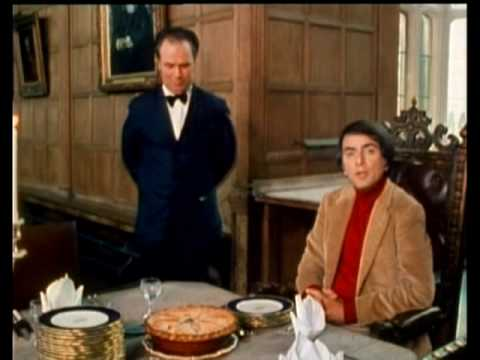

In [10]:
from IPython.display import YouTubeVideo
YouTubeVideo('zSgiXGELjbc')